In [270]:
import pandas as pd
import math
import numpy as np
import itertools
import matplotlib.pyplot as plt

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core.periodic_table import Element
from ase.visualize.plot import plot_atoms

In [271]:
def print_atom_structure(structure):
    ase_atoms = AseAtomsAdaptor.get_atoms(structure)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)

In [272]:
energyForS = 2.693
energyForMo = 7.097

In [273]:
class function_calc:
    def V_z_16_V_z_16(self, x1):
        
        # constant
        
        return  0 - 1/(15+2*x1)
    
    def V_z_42_V_z_42(self, x1):
        
        #0
        
        return (8 / ((np.cos(np.cos(x1)) * np.cos(np.cos(x1))) - (np.exp(x1))))
    
    def V_z_42_V_z_16(self, x1):
    
        return 0 + (((x1 * (np.cos(0.5) * ((np.cos(((0.5 * (4 * (x1 * (4 - x1)))) / x1)) * x1) / x1))) - x1) / ((np.exp(x1)) / x1))
    
    def Se_Se(self, x1):
    
        return 0 +   ((((5 / x1) * 7) - (2 * 9)) / (np.exp(8)))
    
    def Se_V_z_16(self, x1):
    
        return 0 +   (3 / ((x1 / (3 - x1)) - (8**2)))
    
    def Se_V_z_42(self, x1):
    
        return  0 +   (((x1 / np.cos(2)) / 2) / (np.exp((x1 + 1))))
    
    def W_W(self, x1):
    
        #0
        
        return (np.cos(((np.cos(2) * np.cos(2)) * x1)) / (x1 * ((np.exp(x1)) * x1)))
    
    def W_Se(self, x1):
    
        return 0 +   ((-1 - (3 / (x1 - (x1**2)))) / (8**2))
    
    def W_V_z_42(self, x1):
        
        #0
        
        return (np.cos((x1 - (np.cos(7) * np.cos(7)))) / ((np.exp(x1)) + -1))
    
    def W_V_z_16(self, x1):
        
        return 0 +   (((2 - x1) / (7**2)) / x1)
    
    def __call__(self, defect_type1, defect_type2, distance, debug=False):
        all_funcs = [
            'Se_Se', # 0
            'Se_V_z_16', # 1
            'Se_V_z_42', # 2
            'V_z_16_V_z_16', # 3
            'V_z_42_V_z_16', # 4
            'V_z_42_V_z_42', # 5
            'W_Se', # 6
            'W_V_z_16', # 7
            'W_V_z_42', # 8
            'W_W' # 9
        ]
        defect_types = {
            0: 'V_z_16', 
            1: 'V_z_42', 
            2: 'Se', 
            3: 'W'
        }
        call_matrix = [
            [3, 4, 1, 7], 
            [4, 5, 2, 8], 
            [1, 2, 0, 6], 
            [7, 8, 6, 9]
        ]
        
        formation_consts = {
            'V_z_16': 2.645686,
            'V_z_42': 7.121477,
            'Se': 0.278959,
            'W': 0.166689,
        }
        if distance == 0.:
            return formation_consts[defect_types[defect_type1]]
        func_num = call_matrix[defect_type1][defect_type2]
        func = getattr(self, all_funcs[func_num])
        ans = func(distance)
        if debug:
            print(func_num, distance, ans)
        return ans

In [274]:
empty_pickle = pd.read_pickle('emptydata.pkl')
empty_pickle = empty_pickle.iloc[0]
structure = empty_pickle.initial_structure.copy()

In [275]:
from oper import Defect, DefectSet, TopBatch, RandomBatch, BatchOper, EvalFunction

In [276]:
def get_atom(structure, matrices, defect):
    defect_pos = matrices[defect.cords[0]][defect.cords[1]][defect.cords[2]][2]
    atom = structure[int(defect_pos)]
    return atom

In [277]:
def is_Mo(atom):
    return atom.species.as_dict()['Mo'] == 1.0

def is_S1(atom):
    return atom.frac_coords[2] ==  0.144826

def is_S2(atom):
    return atom.frac_coords[2] == 0.355174

In [278]:
def get_atom_id(atom):
    if is_S1(atom):
        return 0
    if is_Mo(atom):
        return 1
    if is_S2(atom):
        return 2
    raise ValueError(f"atom {atom} is not defined")

atom_types = [0, 1, 2]

In [279]:
def get_matrices_MoS2(structure):
    matrices = [[], [], []]
    elements = [[], [], []]
    for idx, atom in enumerate(structure):
        matrices[get_atom_id(atom)].append([atom.frac_coords[0], atom.frac_coords[1], idx])
    for matrix in matrices:
        matrix.sort()
    matrices = np.array(matrices).reshape(3, 8, 8, 3)
    return matrices

In [280]:
matrices = get_matrices_MoS2(structure)

In [281]:
def calc_distance(atom1, atom2):
    x = (atom1.coords[0] - atom2.coords[0]) ** 2
    y = (atom1.coords[1] - atom2.coords[1]) ** 2
    z = (atom1.coords[2] - atom2.coords[2]) ** 2
    distance = math.sqrt(x + y + z)
    return distance

In [282]:
def get_energy(structure, matrices, defect_set, function_set, debug=False):
    energy = 0
    for defect1, defect2, in itertools.combinations_with_replacement(list(defect_set), 2):
        atom1 = get_atom(structure, matrices, defect1)
        atom2 = get_atom(structure, matrices, defect2)
        distance = calc_distance(atom1, atom2)
        energy += function_set(defect1.type, defect2.type, distance, debug)
    return energy

In [283]:
function_set = function_calc()

In [284]:
eval_function = EvalFunction(get_energy, structure, matrices, function_set)

In [285]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
def possible_moves(defect, max_range=1):
    if defect.type == 0 or defect.type == 2:
        return [0, 2], list(range(-max_range, max_range + 1)), list(range(-max_range, max_range + 1))
    if defect.type == 1 or defect.type == 3:
        return [1], list(range(-max_range, max_range + 1)), list(range(-max_range, max_range + 1))

In [287]:
def get_possible_positions(structure, matrices, defect, defect_set, max_range=1):
    possible_positions = []
    for move in itertools.product(*possible_moves(defect, max_range)):
        position = [move[0], defect.cords[1] + move[1], defect.cords[2] + move[2]]
        if not 0 <= position[1] < matrices[position[0]].shape[0]:
            continue
        if not 0 <= position[2] < matrices[position[0]].shape[1]:
            continue
        if Defect(cords=tuple(position)) in defect_set:
            continue
        possible_positions.append(position)
    return possible_positions

In [288]:
import random


def upd_defect_set(structure, matrices, defect_set, max_range=1):
    random_defect = random.sample(defect_set.defect_set, 1)[0]
    defect_set = defect_set.copy()
    defect_set.remove_defect(random_defect)
    possible_positions = get_possible_positions(structure, matrices, random_defect, defect_set, max_range)
    new_sets = []
    for position in possible_positions:
        new_set = defect_set.copy()
        new_set.add_defect(Defect(type=random_defect.type, cords=tuple(position)))
        new_sets.append(new_set)
    return new_sets

In [289]:
target=0

In [290]:
def random_position(defect_type):
    layer = 100
    if defect_type == 0 or defect_type == 2:
        layer = random.choice([0, 2])
    if defect_type == 1 or defect_type == 3:
        layer = 1
        
    x = random.choice(range(matrices[layer].shape[0]))
    y = random.choice(range(matrices[layer].shape[1]))
    return layer, x, y

In [291]:
def random_defects(empty_set, defects):
    new_set = empty_set.copy()
    for defect_type in defects:
        for i in range(defects[defect_type]):
            defect = Defect(defect_type, random_position(defect_type))
            while defect in new_set:
                defect = Defect(defect_type, random_position(defect_type))
            new_set.add_defect(defect)
    return new_set

In [292]:
def mutate(defect_set):
    random_defect = random.sample(defect_set.defect_set, 1)[0]
    defect_set = defect_set.copy()
    defect_set.remove_defect(random_defect)
    possible_positions = get_possible_positions(structure, matrices, random_defect, defect_set, 1)
    position = random.choice(possible_positions)
    new_defect = Defect(type=random_defect.type, cords=tuple(position))
    defect_set.add_defect(new_defect)
    return defect_set

In [293]:
def step_optimize(structure, matrices, batch_op, max_range=1):
    new_sets = []
    for defect_set in batch_op:
        new_sets.extend(upd_defect_set(structure, matrices, defect_set, max_range))
    batch_op.process_members(new_sets)
    for i in range(5):
        batch_op[2].mutate(mutate)
    energies = []
    for defect_set in batch_op:
        energies.append(defect_set.get_energy())
    return np.mean(energies)

In [294]:
def create_printable_structure_MoS2(structure, defects):
    matrices = get_matrices_MoS2(structure)
    ans = structure.copy()
    to_delete = []
    for defect in defects:
        defect_id = int(matrices[defect.cords[0]][defect.cords[1]][defect.cords[2]][2])
        if defect.type == 0 or defect.type == 1:
            to_delete.append(defect_id)
        if defect.type == 2:
            ans.replace(defect_id, Element('Se'))
        if defect.type == 3:
            ans.replace(defect_id, Element('W'))
    ans.remove_sites(to_delete)
    return ans

In [295]:
batch_op = BatchOper([TopBatch(20), RandomBatch(7), TopBatch(15)], target_energy=-1000)
empty_set = DefectSet(eval_function)
defects = {
    0: 2,
    1: 2,
    2: 2,
    3: 2,
}
initial_set = random_defects(empty_set, defects)
batch_op.process_members([initial_set])

In [296]:
energies = []
for i in range(20):
    energies.append(step_optimize(structure, matrices, batch_op))

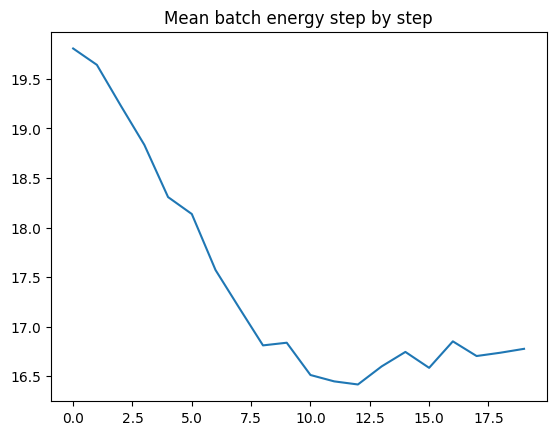

In [297]:
plt.plot(np.array(energies))
plt.title("Mean batch energy step by step")
plt.show()

In [298]:
best_set = batch_op[0].members[0]

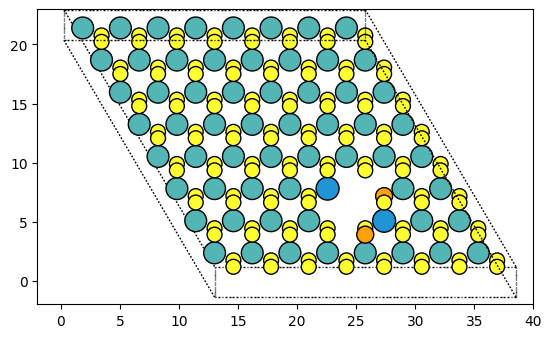

In [299]:
print_atom_structure(create_printable_structure_MoS2(structure, best_set))

In [300]:
best_set.get_energy(debug=True)

8 3.190315614924913 -0.037259258108425466
4 2.416933672897242 -0.9781521819934399
8 3.1903157850750845 -0.03725925512349157
4 2.416933672897242 -0.9781521819934399
2 4.002459370980893 -0.03232286423633369
2 2.416933336003762 -0.09528680951872244
5 3.190315700000003 -0.33329041871678544
7 4.002459710042876 -0.010210352547012844
9 5.525788884584665 7.513263662874511e-05
7 4.002459710042876 -0.010210352547012844
6 2.416933672897234 -0.0019374087617455155
6 2.416933616748322 -0.0019374079013636993
8 3.1903157850750845 -0.03725925512349157
7 2.41693339215267 -0.003520512714763352
3 3.129768733392 -0.047037711971034395
1 3.1903156999999993 -0.03714559308515282
1 4.46917963279444 -0.044748097818983694
4 2.416933616748317 -0.9781521902078351
7 2.41693339215267 -0.003520512714763352
6 5.118378082591563 -0.013401266678971402
6 5.1183781091054685 -0.013401266704806927
8 3.190315614924913 -0.037259258108425466
1 4.46917963279444 -0.044748097818983694
1 3.190315700000001 -0.03714559308515288
4 2.41

15.503166248833828

In [301]:
def get_atom_from_cords(coords, structure):
    for idx, atom in enumerate(structure):
        if (abs(atom.frac_coords - coords) < 0.01).all():
            yield idx, atom

In [302]:
def get_atom_id(coords, structure):
    return list(get_atom_from_cords(coords, structure))[0][0]

In [303]:
def get_matrices_coords(id):
    return tuple(arr[0] for arr in np.where(matrices == id)[:3])

In [304]:
get_atom_id((0.042, 0.333, 0.25),structure)

2

In [305]:
get_matrices_coords(get_atom_id((0.042, 0.333, 0.25),structure))

(1, 0, 2)

In [314]:
d0 = Defect(1, get_matrices_coords(get_atom_id((0.042, 0.333, 0.25),structure)))
d1 = Defect(0, get_matrices_coords(get_atom_id((0.208, 0.167, 0.145),structure)))
d2 = Defect(2, get_matrices_coords(get_atom_id((0.083333, 0.291667, 0.355174),structure)))
d_set = DefectSet(eval_function)
d_set.add_defect(d0)
d_set.add_defect(d1)
d_set.add_defect(d2)
d_set.get_energy(debug=True) # 3.283003

1 6.350574393038605 -0.0455267198826849
2 2.4169333921526697 -0.09528680638212458
4 7.532073811885252 -0.011447137868792274


3.2979537786221322

In [312]:
d0 = Defect(1, get_matrices_coords(get_atom_id((0.667,  0.333,  0.25),structure)))
d1 = Defect(0, get_matrices_coords(get_atom_id((0.333,  0.667,  0.145),structure)))
d2 = Defect(0, get_matrices_coords(get_atom_id((0.958,  0.042,  0.145),structure)))
d_set = DefectSet(eval_function)
d_set.add_defect(d0)
d_set.add_defect(d1)
d_set.add_defect(d2)
d_set.get_energy(debug=True) # 4.151911

3 27.62894427556897 -0.0142332771539546
4 14.81829839810725 -0.00014685131546460654
4 12.988125048950918 -0.00016836000242477695


4.132766837176052

In [313]:
d0 = Defect(2, get_matrices_coords(get_atom_id((0.833333,  0.916667,  0.144826),structure)))
d1 = Defect(2, get_matrices_coords(get_atom_id((0.958333,  0.291667,  0.355174),structure)))
d_set = DefectSet(eval_function)
d_set.add_defect(d0)
d_set.add_defect(d1)
d_set.get_energy(debug=True) # 0.289753

0 18.036546081780163 -0.005387360541572091


0.276265319729214

In [315]:
d0 = Defect(1, get_matrices_coords(get_atom_id((0.792,  0.208,  0.25),structure)))
d1 = Defect(0, get_matrices_coords(get_atom_id((0.208,  0.917,  0.145),structure)))
d2 = Defect(0, get_matrices_coords(get_atom_id((0.208,  0.667,  0.355),structure)))
d_set = DefectSet(eval_function)
d_set.add_defect(d0)
d_set.add_defect(d1)
d_set.add_defect(d2)
d_set.get_energy(debug=True) # 4.140348

4 23.132304683382323 -1.2461444815355324e-08
4 28.63722622597179 -1.5568141927912227e-10
3 7.106891758909071 -0.03423041727512212


4.126206190035917